# Домашнее задание № 8

## по дисциплине: Теория вероятностей и математическая статистика

## Тема: Дисперсионный анализ. Метод главных компонент. Логистическая регрессия

### выполнил: Евгений Кириллов

__Задача 1__

Используя данные о хоккеистах (скачать можно [здесь](https://habr.com/ru/post/301340/)), проверьте, является ли среди хоккеистов из Финляндии, Норвегии и Дании значимым отличие роста. В качестве ответа запишите 1, если является, и 0 иначе.

_Подсказка_: не забудьте предобработать данные (например, дублируются ли данные о конкретных игроках?).

__Ответ__: 1

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_formats = ['svg']

In [2]:
df = pd.read_csv('hockey_players.csv')
df.head()

,year,country,no,name,position,side,height,weight,birth,club,age,cohort,bmi
0,2001,RUS,10,tverdovsky oleg,D,L,185,84.0,1976-05-18,anaheim mighty ducks,24.952772,1976,24.543462
1,2001,RUS,2,vichnevsky vitali,D,L,188,86.0,1980-03-18,anaheim mighty ducks,21.119781,1980,24.332277
2,2001,RUS,26,petrochinin evgeni,D,L,182,95.0,1976-02-07,severstal cherepovetal,25.229295,1976,28.680111
3,2001,RUS,28,zhdan alexander,D,R,178,85.0,1971-08-28,ak bars kazan,29.675565,1971,26.827421
4,2001,RUS,32,orekhovsky oleg,D,R,175,88.0,1977-11-03,dynamo moscow,23.490760,1977,28.734694


напишем функцию, которая убирает дубли в списках игроков и трансформирует датафрэйм в массив значений роста игроков

In [3]:
def remove_doubles(df_of_players):
    
    doubles = df_of_players['name'].value_counts()[df_of_players['name'].value_counts() > 1].index
    
    indexes_of_objects_to_delete = []
    for name in doubles:
        for index in df_of_players.loc[df_of_players['name'] == name].index[1:]:
            indexes_of_objects_to_delete.append(index)
    df_of_players = df_of_players.drop(indexes_of_objects_to_delete)['height']

    return df_of_players.values

при помощи написанной выше функции сформируем три выборки по командам: FIN, NOR, DEN

In [4]:
y1 = remove_doubles(df[df['country'] == 'FIN'].copy())
y2 = remove_doubles(df[df['country'] == 'NOR'].copy())
y3 = remove_doubles(df[df['country'] == 'DEN'].copy())

найдём количество объектов в каждой выборке

In [5]:
n1 = y1.shape[0]
n2 = y2.shape[0]
n3 = y3.shape[0]

n1, n2, n3

(200, 98, 132)

найдём выборочные средние по каждой выборке

In [6]:
y1_mean = y1.mean()
y2_mean = y2.mean()
y3_mean = y3.mean()

y1_mean, y2_mean, y3_mean

(184.34, 182.72448979591837, 184.1818181818182)

проверим статистическую значимость этих отличий

для этого соберём все значения выборок в один массив

In [7]:
y = np.concatenate([y1, y2, y3])

найдём его среднее

In [8]:
y_mean = y.mean()
y_mean

183.9232558139535

найдём внешние и внутренние суммы квадратов

In [9]:
SS_b = n1 * (y1_mean - y_mean) ** 2 + n2 * (y2_mean - y_mean) ** 2 + n3 * (y3_mean - y_mean) ** 2

SS_w = ((y1 - y1_mean) ** 2).sum() + ((y2 - y2_mean) ** 2).sum() + ((y3 - y3_mean) ** 2).sum()

SS_b, SS_w

(184.3898537343051, 11088.07758812616)

запишем оценки дисперсий

In [10]:
k = 3
n = n1 + n2 + n3

k1 = k - 1
k2 = n - k

sigma2_b = SS_b / k1
sigma2_w = SS_w / k2

sigma2_b, sigma2_w

(92.19492686715255, 25.967394819967588)

найдём значение статистики  𝐹

In [11]:
F = sigma2_b / sigma2_w
F

3.5504111023204916

зафиксируем уровень значимости  𝛼=0.05, найдём для него нужный квантиль

In [12]:
alpha = 0.05

t = stats.f.ppf(1 - alpha, k1, k2)
t

3.0168482792459144

Итак, наша критическая область имеет вид:
$$\Omega_\alpha = \left( 3.01, \infty \right)$$

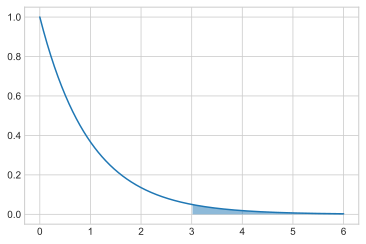

In [13]:
ox = np.linspace(0, 6, 500)
oy = stats.f.pdf(ox, k1, k2)

ox_right = np.linspace(t, 6, 100)
oy_right = stats.f.pdf(ox_right, k1, k2)

plt.plot(ox, oy)
plt.fill_between(ox_right, oy_right, alpha=0.5)

значение статистики попало в критическую область, поэтому заключаем, что отличие роста по странам действительно является статистически значимым

проверим результат с помощью штатной реализации однофакторного дисперсионного анализа из библиотеки scipy

In [14]:
stats.f_oneway(y1, y2, y3)

F_onewayResult(statistic=3.5504111023205005, pvalue=0.029563539043363198)